# Introduction

Previously we saw the RSA algorithm which is an asymmetrical key encryption algorithm. That means the encryption adn decryption keys are different. As a result, the encryption key can be public.
Another approach is the symmetrical key is different. The same key can encrypt and decrypt messages. As a result, you cannot give publicly the key. 

<img src="Symmetric-Encryption.png"/>

The common way to create a key between 2 pair in this case is to use the Diffie Hellman Algorithm. This is what we will see in this Notebook.

In [15]:
import matplotlib.pyplot as plt
import random
from sympy import mod_inverse

# Diffie Hellman  key exchange

## Principle

The principle is quite simple and can be represented as follow :

- Alice and Bob picks 2 random secret numbers(N). They share in a public canal 2 other number (P and G).
- They both compute the public key by doing $ G^N mod(P) $
- They share publicly those numbers (it's quite difficult to find the private number at this stage due to the modulo)
- Alice and Bob take the other one's public key and do the same calculation on it.
- The result is the key. It is the same because :

$$ key_{Alice} = ({G^{N_{Alice}}})^{N_{Bob}} \pmod{P} = ({G^{N_{Bob}}})^{N_{Alice}} \pmod{P} = key_{Bob} $$

<img src="diffie.png"/>

Now let's implement it !

## Implementation

### Pick random primes numbers (4 required)

We need to generate 4 random primes. They will be used for Alice and Bob private number, G and P. As the length of the number must be quite big to be safe, to find a prime we should use Primality tests like the Baillie-PSW primality test or Fermat primality test. There is only a few risk to find a Carmichael numbers which is a non-primes number passing the test (because it's a product of primes). However, the bigger the number is, the less probability it will be a Carmichael number.

In [16]:
from random import randrange, getrandbits

def is_prime(n, k=128):
    """ Test if a number is prime
        Args:
            n -- int -- the number to test
            k -- int -- the number of tests to do
        return True if n is prime
    """
    # Test if n is not even.
    # But care, 2 is prime !
    if n == 2 or n == 3:
        return True
    if n <= 1 or n % 2 == 0:
        return False
    # find r and s
    s = 0
    r = n - 1
    while r & 1 == 0:
        s += 1
        r //= 2
    # do k tests
    for _ in range(k):
        a = randrange(2, n - 1)
        x = pow(a, r, n)
        if x != 1 and x != n - 1:
            j = 1
            while j < s and x != n - 1:
                x = pow(x, 2, n)
                if x == 1:
                    return False
                j += 1
            if x != n - 1:
                return False
    return True

def generate_prime_candidate(length):
    """ Generate an odd integer randomly
        Args:
            length -- int -- the length of the number to generate, in bits
        return a integer
    """
    # generate random bits
    p = getrandbits(length)
    # apply a mask to set MSB and LSB to 1
    p |= (1 << length - 1) | 1
    return p

def generate_prime_number(length=1024):
    """ Generate a prime
        Args:
            length -- int -- length of the prime to generate, in bits
        return a prime
    """
    p = 4
    # keep generating while the primality test fail
    while not is_prime(p, 128):
        p = generate_prime_candidate(length)
    return p

value = [generate_prime_number(100) for _ in range(4)]

Non we have 4 primes of 100 bits. let's just show them.

In [3]:
value

[704950475552681104039337025661,
 1009547851453184087829709585483,
 960420900446383995669821589017,
 1166956362235757427901973258417]

## Creation of the encryption key

Now we can do the differents step of the DH algorithm. Just to see what is visible to who, I'll create objects for the Public Environment and Personnal Environments with the value existing in each domains. After each steps, I'll printi the content of each objects

In [17]:
class PublicDomain:
    def __init__(self, g, p):
        self.g = g
        self.p = p
        self.key_a = None
        self.key_b = None
        
class User:
    def __init__(self, private_number, ph):
        self.private_number = private_number
        self.partial_key = None
        self.key = None
        self.ph = ph
    
    def make_key(self, public_domain):
        if self.partial_key is None:
            self.partial_key = pow(public_domain.g, self.private_number, public_domain.p)
        else:
            if self.ph == "a":
                other_partial_key = public_domain.key_b
            else:
                other_partial_key = public_domain.key_a
            self.key = pow(other_partial_key, self.private_number, public_domain.p)
    
    def share(self, to):
        if self.ph == "a":
            to.key_a = self.partial_key 
        else:
            to.key_b = self.partial_key 

### Step 1 : Initialization

In [18]:
public = PublicDomain(value[0], value[1])
alice = User(value[2], "a")
bob = User(value[3], "b")

In [6]:
display(public.__dict__)
display(alice.__dict__)
display(bob.__dict__)

{'g': 704950475552681104039337025661,
 'key_a': None,
 'key_b': None,
 'p': 1009547851453184087829709585483}

{'key': None,
 'partial_key': None,
 'ph': 'a',
 'private_number': 960420900446383995669821589017}

{'key': None,
 'partial_key': None,
 'ph': 'b',
 'private_number': 1166956362235757427901973258417}

### Public Key creation

In [7]:
alice.make_key(public)
bob.make_key(public)

In [8]:
display(public.__dict__)
display(alice.__dict__)
display(bob.__dict__)

{'g': 704950475552681104039337025661,
 'key_a': None,
 'key_b': None,
 'p': 1009547851453184087829709585483}

{'key': None,
 'partial_key': 964452089110735253604950791036,
 'ph': 'a',
 'private_number': 960420900446383995669821589017}

{'key': None,
 'partial_key': 591260650512209002823394738458,
 'ph': 'b',
 'private_number': 1166956362235757427901973258417}

### Sharing public keys

In [9]:
alice.share(public)
bob.share(public)

In [10]:
display(public.__dict__)
display(alice.__dict__)
display(bob.__dict__)

{'g': 704950475552681104039337025661,
 'key_a': 964452089110735253604950791036,
 'key_b': 591260650512209002823394738458,
 'p': 1009547851453184087829709585483}

{'key': None,
 'partial_key': 964452089110735253604950791036,
 'ph': 'a',
 'private_number': 960420900446383995669821589017}

{'key': None,
 'partial_key': 591260650512209002823394738458,
 'ph': 'b',
 'private_number': 1166956362235757427901973258417}

### Creating final key

In [11]:
alice.make_key(public)
bob.make_key(public)

In [12]:
display(public.__dict__)
display(alice.__dict__)
display(bob.__dict__)

{'g': 704950475552681104039337025661,
 'key_a': 964452089110735253604950791036,
 'key_b': 591260650512209002823394738458,
 'p': 1009547851453184087829709585483}

{'key': 782948956039328309725355865899,
 'partial_key': 964452089110735253604950791036,
 'ph': 'a',
 'private_number': 960420900446383995669821589017}

{'key': 782948956039328309725355865899,
 'partial_key': 591260650512209002823394738458,
 'ph': 'b',
 'private_number': 1166956362235757427901973258417}

And we can see that both bipartites have the same key and it was never shared in the public domain. However, the creation of the key is quite simple and is not as safe as possible. Another approch is to use the mathematics in Elliptic curves. This provides a safer key (for the same size) or a shorter key (for the same safety).

## Elliptic Curve Algorithm (Elliptic-curve Diffie–Hellman (ECDH))

There is no difference regarding the way of sharing keys (the Diffie-Hellman part) but the difference is how the public key is generated from the private number. This new method is slowly replacing the previous method or the RSA due to his the level of security. For example, for a top-secret level encryption, the NSA recommand a key of 384 bits using ECC. To get the same level of security using RSA, it requires a key of 7680 bits. Currently, the RSA is maintly used with a 1024 bits keys which is equivalent to 160 bits key with ECC.

### What is an Elliptic Curve

An Elliptical curve has an equation like $ y² = x^3 + ax + b $ (often but not always - see <a href="https://safecurves.cr.yp.to/">this link</a>). In this Notebook, we will use one of the most common one (but not the safest) used for bitcoin which is the secp256k1. The equation is $ y² = x^3 + 7 $.

On this curve, there is a starting point G = (GX, GY). We can do arithmetic on points in this curve. The computation will be explained on the next section.

The safety of this algorithm is not based on the starting point (because it's a public value) but the number $ k $ which is the number of times, you will multiply the point by itself. This number is often above $ 2^{200} $ to be sure to not be able to bruteforce it. As a result, to compute the key in an efficient way, the method Double-and-add is required (also called fast exponentiation).

### Computation in Elliptic curve

We can represent the addition of 2 points on an Elliptical Curve as follow :

<img src="Elliptical_curve.jpeg"/>

On a curve, to sum 2 points P and Q, there is 2 cases:

- Case P != Q :

In this case, the theory says that you should draw a line between those 2 points and find the 3rd intersection point with the curve. This point will have a coordinate (X, Y). The result of P+Q is (X, -Y).

Mathematically, in a curve with an equation represented as $ y² = x^3 + ax + b $, the position of R will be :

\begin{align*} 
\lambda &= (Y_q - Y_p)/(X_q - X_p) \\ 
X_r &= \lambda² - X_p - X_q &\pmod{p} \\
Y_r &= \lambda*(X_p - X_r) - Y_p &\pmod{p} \\
\end{align*}

- Case P == Q :

If P = Q, the tangent of the curve at the point P is used. This tangent will intersect the curve on a 2nd point (X, Y). Identically to the previous case, the result of P+P = (X, -Y).

Mathematically, it just a replacement of $ \lambda $ to $$ \lambda = \frac{3X_p² + a}{2Y_p} $$

Several informations are also available on following links :
- https://www.youtube.com/watch?v=dCvB-mhkT0w
- https://www.youtube.com/watch?v=UREbmgNzncY
- https://hackernoon.com/what-is-the-math-behind-elliptic-curve-cryptography-f61b25253da3

Let's now implement it. The following code is mainly found on the internet and was used to understand all the mechanic of the fast exponentiation and maths behind Elliptic Curve. The code being very clean, I didn't touched it a lot.

In [21]:
class EllipticCurve(object):
    """Represents a single elliptic curve defined over a finite field.

    See here:
        http://en.wikipedia.org/wiki/Elliptic_curve
        http://jeremykun.com/2014/02/24/elliptic-curves-as-python-objects/

    p must be prime, since we use the modular inverse to compute point
    addition.

    """
    def __init__(self, a, b, p):
        self.a = a
        self.b = b
        self.p = p

    def __eq__(self, C):
        return (self.a, self.b) == (C.a, C.b)

    def has_point(self, x, y):
        return (y ** 2) % self.p == (x ** 3 + self.a * x + self.b) % self.p

    def __str__(self):
        return 'y^2 = x^3 + {}x + {}'.format(self.a, self.b)

In [22]:
class Point(object):
    """A point on a specific curve."""
    def __init__(self, curve, point):
        self.curve = curve
        self.x = point[0] % curve.p
        self.y = point[1] % curve.p

    def __str__(self):
        return '({}, {})'.format(self.x, self.y)

    def __getitem__(self, index):
        return [self.x, self.y][index]

    def __eq__(self, Q):
        return (self.curve, self.x, self.y) == (Q.curve, Q.x, Q.y)

    def __neg__(self):
        return Point(self.curve, self.x, -self.y)
    
    def __add__(self, Q):
        """Add two points together.

        We need to take care of special cases:
         * Q is the infinity point (0)
         * P == Q
         * The line crossing P and Q is vertical.

        """

        # 0 + P = P
        if isinstance(Q, Inf):
            return self

        xp, yp, xq, yq = self.x, self.y, Q.x, Q.y
        m = None

        # P == Q
        if self == Q:
            if self.y == 0:
                R = Inf(self.curve)
            else:
                m = ((3 * xp * xp + self.curve.a) * mod_inverse(2 * yp, self.curve.p)) % self.curve.p

        # Vertical line
        elif xp == xq:
            R = Inf(self.curve)

        # Common case
        else:
            m = ((yq - yp) * mod_inverse(xq - xp, self.curve.p)) % self.curve.p

        if m is not None:
            xr = (m ** 2 - xp - xq) % self.curve.p
            yr = (m * (xp - xr) - yp) % self.curve.p
            R = Point(self.curve, (xr, yr))

        return R
    
    def __mul__(self, n):

        n = n % self.curve.p

        if n == 0:
            return Inf(self.curve)

        else:
            Q = self
            R = Inf(self.curve)

            i = 1
            while i <= n:
                if n & i == i:
                    R = R + Q

                Q = Q + Q

                i = i << 1

        return R

    def __rmul__(self, n):
        return self * n

In [23]:
class Inf(Point):
    """The custom infinity point."""
    def __init__(self, curve):
        self.curve = curve

    def __eq__(self, Q):
        return isinstance(Q, Inf)

    def __neg__(self):
        """-0 = 0"""
        return self
    
    def __add__(self, Q):
        """P + 0 = P"""
        return Q

New we have the EC Generator created. Let's do the same as previously with the public and private Domain for the complete creation of the key. That required only few changes on classes but the rest is identical (as we don't touch the DH part)

In [16]:
class PublicDomain:
    def __init__(self, curve, point):
        self.curve = curve
        self.starting_point = point
        self.key_a = None
        self.key_b = None
        
class User:
    def __init__(self, private_number, ph):
        self.private_number = private_number
        self.partial_key = None
        self.key = None
        self.ph = ph
    
    def make_key(self, public_domain):
        if self.partial_key is None:
            self.partial_key = self.private_number * public_domain.starting_point
        else:
            if self.ph == "a":
                other_partial_key = public_domain.key_b
            else:
                other_partial_key = public_domain.key_a
            self.key = (self.private_number * other_partial_key)[0]
    
    def share(self, to):
        if self.ph == "a":
            to.key_a = self.partial_key 
        else:
            to.key_b = self.partial_key 

In [17]:
# Curve parameter
P = 0xFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFEFFFFFC2F
A = 0
B = 7
GX = 0x79BE667EF9DCBBAC55A06295CE870B07029BFCDB2DCE28D959F2815B16F81798
GY = 0x483ADA7726A3C4655DA4FBFC0E1108A8FD17B448A68554199C47D08FFB10D4B8
G = (GX, GY)
N = 0XFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFEBAAEDCE6AF48A03BBFD25E8CD0364141

In [18]:
curve = EllipticCurve(A, B, P)
point = Point(curve, G)

In [19]:
public = PublicDomain(curve, point)
alice = User(random.randint(1, N - 1), "a")
bob = User(random.randint(1, N - 1), "b")

In [20]:
display(public.__dict__)
display(alice.__dict__)
display(bob.__dict__)

{'curve': <__main__.EllipticCurve at 0x1d413750160>,
 'key_a': None,
 'key_b': None,
 'starting_point': <__main__.Point at 0x1d413750198>}

{'key': None,
 'partial_key': None,
 'ph': 'a',
 'private_number': 74127076595939689778894480112641342701979676063173869625241276020165068553580}

{'key': None,
 'partial_key': None,
 'ph': 'b',
 'private_number': 71988997438990585073135192040329629184957237384010973007119814614900553006258}

In [21]:
alice.make_key(public)
bob.make_key(public)

In [22]:
display(public.__dict__)
display(alice.__dict__)
display(bob.__dict__)

{'curve': <__main__.EllipticCurve at 0x1d413750160>,
 'key_a': None,
 'key_b': None,
 'starting_point': <__main__.Point at 0x1d413750198>}

{'key': None,
 'partial_key': <__main__.Point at 0x1d4137364e0>,
 'ph': 'a',
 'private_number': 74127076595939689778894480112641342701979676063173869625241276020165068553580}

{'key': None,
 'partial_key': <__main__.Point at 0x1d413736c50>,
 'ph': 'b',
 'private_number': 71988997438990585073135192040329629184957237384010973007119814614900553006258}

In [23]:
alice.share(public)
bob.share(public)

In [24]:
display(public.__dict__)
display(alice.__dict__)
display(bob.__dict__)

{'curve': <__main__.EllipticCurve at 0x1d413750160>,
 'key_a': <__main__.Point at 0x1d4137364e0>,
 'key_b': <__main__.Point at 0x1d413736c50>,
 'starting_point': <__main__.Point at 0x1d413750198>}

{'key': None,
 'partial_key': <__main__.Point at 0x1d4137364e0>,
 'ph': 'a',
 'private_number': 74127076595939689778894480112641342701979676063173869625241276020165068553580}

{'key': None,
 'partial_key': <__main__.Point at 0x1d413736c50>,
 'ph': 'b',
 'private_number': 71988997438990585073135192040329629184957237384010973007119814614900553006258}

In [25]:
alice.make_key(public)
bob.make_key(public)

In [26]:
display(public.__dict__)
display(alice.__dict__)
display(bob.__dict__)

{'curve': <__main__.EllipticCurve at 0x1d413750160>,
 'key_a': <__main__.Point at 0x1d4137364e0>,
 'key_b': <__main__.Point at 0x1d413736c50>,
 'starting_point': <__main__.Point at 0x1d413750198>}

{'key': 66118776497877264828550845311939106021675372074027998768267183491636278236385,
 'partial_key': <__main__.Point at 0x1d4137364e0>,
 'ph': 'a',
 'private_number': 74127076595939689778894480112641342701979676063173869625241276020165068553580}

{'key': 66118776497877264828550845311939106021675372074027998768267183491636278236385,
 'partial_key': <__main__.Point at 0x1d413736c50>,
 'ph': 'b',
 'private_number': 71988997438990585073135192040329629184957237384010973007119814614900553006258}

And that's it. both bipartites have the same key without sending it in clear ! 

### Codingame puzzle

I proposed this as a puzzle on codingame but with a key limited to 2^62 to ensure that everybody is able to do the puzzle. This are the generator of the test cases

In [19]:
P = 0x3fddbf07bb3bc551
A = 0
B = 7
GX = 0x69d463ce83b758e
GY = 0x287a120903f7ef5c  # determined afterward
G = (GX, GY)
N = 0x287a120903f7ef5c

However, I fixed a Starting point X on the curve (smaller) and a P (also < 2^62). I have now to find the y such as :

$$ y^2 \pmod{P} == x^3 + 7 \pmod{P} $$

To do so, I need to compute the modular square root of $ y^2 $. This can be found using Tonelli's Algorithm (implementation found on the internet)

In [3]:
(GX**3 + 7)%P

113447140063769483

In [13]:
(GY**2)%P

113447140063769483

In [7]:
def legendre(a, p):
    return pow(a, (p - 1) // 2, p)
 
def tonelli(n, p):
    assert legendre(n, p) == 1, "not a square (mod p)"
    q = p - 1
    s = 0
    while q % 2 == 0:
        q //= 2
        s += 1
    if s == 1:
        return pow(n, (p + 1) // 4, p)
    for z in range(2, p):
        if p - 1 == legendre(z, p):
            break
    c = pow(z, q, p)
    r = pow(n, (q + 1) // 2, p)
    t = pow(n, q, p)
    m = s
    t2 = 0
    while (t - 1) % p != 0:
        t2 = (t * t) % p
        for i in range(1, m):
            if (t2 - 1) % p == 0:
                break
            t2 = (t2 * t2) % p
        b = pow(c, 1 << (m - i - 1), p)
        r = (r * b) % p
        c = (b * b) % p
        t = (t * c) % p
        m = i
    return r

In [5]:
y_squared = int(((GX**3 + A*GX + B)%P))
y_squared

113447140063769483

In [8]:
GY = tonelli(y_squared, P)

In [9]:
int((GY**2)%P)

113447140063769483

In [12]:
hex(GY)

'0x287a120903f7ef5c'

And we have our GY. We can now, generate our samples

In [24]:
curve = EllipticCurve(A, B, P)
point = Point(curve, G)

In [25]:
k=2
print(hex((k * point)[0]))

0x2544b2250b8b1e1c


In [26]:
k=3
print(hex((k * point)[0]))

0x16cc969206bac6ef


In [27]:
for k in [2, 4, 6]:
    print(hex((k * point)[0]))

0x2544b2250b8b1e1c
0x1b7627b83fb2fb72
0x1eb4c74b285a26a0


In [28]:
for k in [3, 5, 7]:
    print(hex((k * point)[0]))

0x16cc969206bac6ef
0xdad6df5e65656cc
0x1ae3107d8fee8800


In [29]:
temp = []
for k in range(100, 150):
    temp.append((hex(k), hex((k * point)[0])))
    
for a, b in temp:
    print(a)
for a, b in temp:
    print(b)

0x64
0x65
0x66
0x67
0x68
0x69
0x6a
0x6b
0x6c
0x6d
0x6e
0x6f
0x70
0x71
0x72
0x73
0x74
0x75
0x76
0x77
0x78
0x79
0x7a
0x7b
0x7c
0x7d
0x7e
0x7f
0x80
0x81
0x82
0x83
0x84
0x85
0x86
0x87
0x88
0x89
0x8a
0x8b
0x8c
0x8d
0x8e
0x8f
0x90
0x91
0x92
0x93
0x94
0x95
0x3449f7da6eab649d
0x27360b9a43d7231b
0x53cf11f0f515254
0x3e5f5f1939ab30
0x32bfdf549c44e27e
0x1cb4bccb3f5cbf06
0xbeded34788cae
0x3b6f22009eb1bb74
0x31282d8f804b7f3c
0x21efaead80c99114
0x300098d8c0f3bf2f
0x35172b967fd773d7
0x38119526a4a86e76
0x36b9de9af880e617
0x48bafb1e29963a6
0x39dcec7f5c3d6de9
0x34d1c59c164b149
0x28d672654774f96
0x1f36e7c20252d69f
0x24f739e70129405
0x269539d4ac317bb8
0x3522ec3f839ec040
0x3b4e0949e123aff1
0xa684f4c3a77a060
0x34a7b68e06615b2
0x3a20300cffe72222
0x213ed2511df25634
0x2cfc8a524643c12d
0x99c3663ac2cf4ba
0xed0d1f1cbf2b470
0x1e9613377509ace6
0x130bff201c6f8a03
0x21f3a686e8de9fcf
0x3db0535e7d5d299
0x1f8b05c782168f12
0x6456bfb63e80bdc
0xfce5c6ddd6bd559
0x3d16880dfe6b932f
0xbe407c03769883c
0x3c30aa945abd9a80
0x252bd5

In [30]:
temp = []
for k in range(150, 200):
    temp.append((hex(k), hex((k * point)[0])))

for a, b in temp:
    print(a)
for a, b in temp:
    print(b)

0x96
0x97
0x98
0x99
0x9a
0x9b
0x9c
0x9d
0x9e
0x9f
0xa0
0xa1
0xa2
0xa3
0xa4
0xa5
0xa6
0xa7
0xa8
0xa9
0xaa
0xab
0xac
0xad
0xae
0xaf
0xb0
0xb1
0xb2
0xb3
0xb4
0xb5
0xb6
0xb7
0xb8
0xb9
0xba
0xbb
0xbc
0xbd
0xbe
0xbf
0xc0
0xc1
0xc2
0xc3
0xc4
0xc5
0xc6
0xc7
0x23dbfc76044b6bc4
0x17851ccf36d03f3e
0x80b2f04534fc093
0x199969f93ce4ad1d
0x2c570597f9ed01a2
0x3ba5fc1cbe3a5e75
0xd3290683fbb0d52
0x2ca78f534a948c0a
0x1ad517789cf69b80
0x2854777bf0d4e8d9
0xaf25fa9929fc48d
0x2a2794fa8d9a44ff
0xec214adca336993
0xa36b60334f6a37e
0x2705df31907ff441
0x2c602c8ece6591d0
0xa0a2b67c368691b
0x12eb2fe6ef75fe8e
0x292ff1b1277b8e9e
0x3e151263898eddb3
0x16f145066ef17fb0
0x314c8161876a29ae
0xf21d1931658abd9
0x7f5b1c7576b2fde
0x2d5975c956004cc9
0x10d561d67aa0f87
0x3aef241e432e88cf
0x347ec877752ead14
0x2bfc14f5c28c8236
0x526dd9ba9be6d17
0x2bb71d3c8bd72213
0x3b0e3890154ce29
0x1085cb0188baf07
0x36bdbe5a91432dc4
0x1833664e2b8b2298
0x1e5dfcf4c952bf13
0x2ac80c50b7645863
0x3d40594745d31b0a
0x32790a4a5e6c6315
0x3f8ad66792898024
0x

In [41]:
random.seed(42)

In [43]:
k = random.randint(1, N - 1)
print(hex(k))
print(hex((k * point)[0]))

0xfac4ee446685258
0x35fb9ec5471bc3c1


In [44]:
random.seed(42)

In [46]:
temp = []
for i in range(50):
    k = random.randint(1, N - 1)
    temp.append((hex(k), hex((k * point)[0])))
for a, b in temp:
    print(a)
print("")
for a, b in temp:
    print(b)

0x8efb40743cf2fdf
0x227e9a9a8fb5d27c
0x1b6b75b195a76d7a
0x25589a7ce5d7b876
0x172af325663f1c98
0x8da6d61ff5e9ff1
0x1f95c377827050a9
0x9c826f71c11f736
0xa3d2520a0a04dc5
0x262b90cd6c12ace9
0x18a0071110435a11
0x2623093261b1cd23
0x1df48780ff01cf9a
0x10172b3b877409aa
0x23680d96f89897ba
0x754d0d2b88139ba
0x15c56f5ba4161294
0x12c8b4c21c8eaeea
0xa1f41b26f4cc69b
0x352bd674273ca4
0x207ddb472dbc2135
0x6cf6f57e9a1fa70
0x2804eb1bdeda4e17
0x207d8c75a39231a8
0xcbaf5a29be578c8
0x17ee345b2720797e
0xa56d1c5c333e862
0x26551bad00257ad2
0x1f4550e152fbe43c
0x728d73e04fc6d83
0x173b13adedd96832
0xf532fcd4eb93f00
0xf6a70aa0ed42f1b
0x244f9378e0c53cb9
0x50a5b01f26b4777
0x2217db99c2b6d2c6
0x80c75d4c40db9b5
0xa9170aa8cbfedb1
0x21c5684043dac044
0x26d26f49df57c59b
0x198916fe4fcca39b
0x17e61f1ca65e688f
0x1ce52623847fd9b5
0xfddaf871efa2198
0x41900173985c3d0
0x158a016568cc69c
0x23737340969b6663
0x25a900bc3ae8cc94
0x75d09538602ab7
0x3c49678a18ff6b7

0x5e57f6c98b0291b
0x159fdfad1e8a0b9b
0x1158330dda9931c6
0x39c53194feb439

## Random Generator

Finally, we can use the EC Generator to generate random numbers. To do so, we just have to divide the position by the modulo to be between 0 and 1. Let's plot a random generation

In [36]:
random.randint(1, N - 1)

99811396086705133210345876639284612396548352959466567532322533769945821630502

In [37]:
Coords_random_k = []
for i in range(100):
    k = random.randint(1, N - 1)
    point = Point(curve, G)
    a = k * point
    Coords_random_k.append((a[0]/curve.p, a[1]/curve.p))

In [38]:
Coords_following_k = []
s = 31460925377429881921015765066241872529280843485718281616584589487819226411463
for k in range(s, s+100):
    point = Point(curve, G)
    a = k * point
    Coords_following_k.append((a[0]/curve.p, a[1]/curve.p))

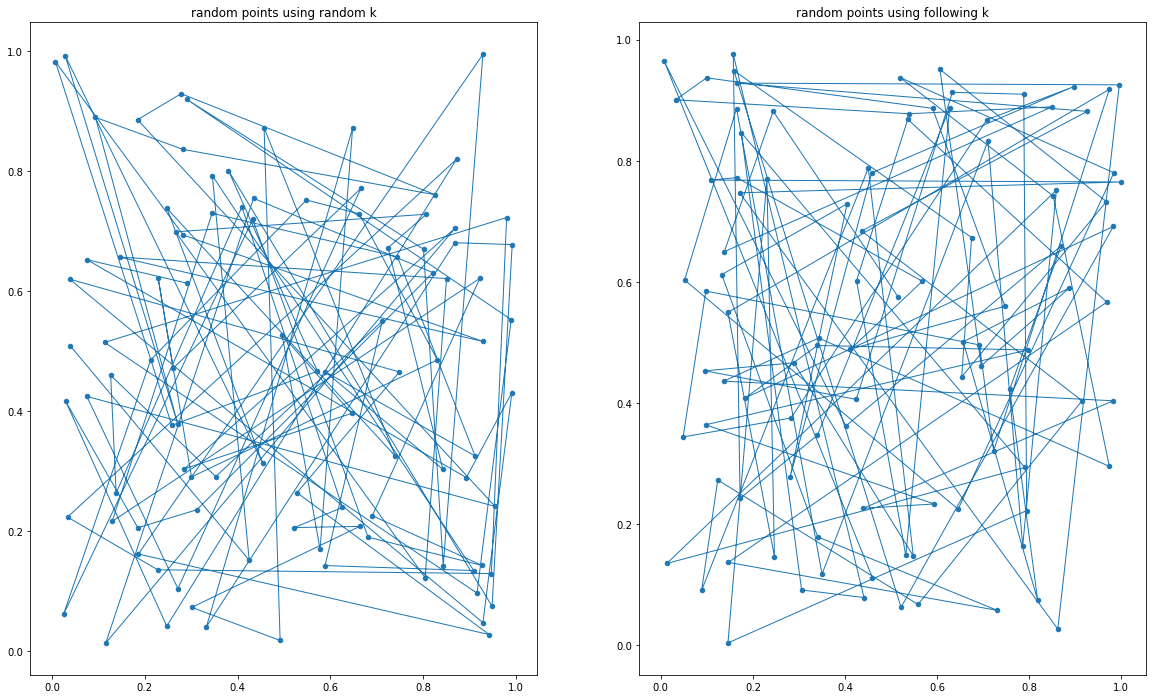

In [39]:
atemp = list(zip(*Coords_random_k))
btemp = list(zip(*Coords_following_k))

fix, (ax, ax2) = plt.subplots(1, 2, figsize=(20,12))
ax.plot(atemp[0], atemp[1], linewidth=1)
ax.scatter(atemp[0], atemp[1], s=20)
ax2.plot(btemp[0], btemp[1], linewidth=1)
ax2.scatter(btemp[0], btemp[1], s=20)
ax.set_title("random points using random k")
ax2.set_title("random points using following k")
plt.show()

We can see that even if k is a known sequence, it allows to create a random sequence. This could be use for example as a seed. The seed will be the starting k. After the EC Generator will generate random 2D points which could be repeated. 

# Conclusion

In this Notebook, we implemented the Diffie Hellman Key Exchange Algorithm with a Basic Key creation and a Safer one based on Elliptical Curves. This allow the creation of a symmetrical key. We will see in the next Notebook, how to use this key to encrypt/decrypt a file (there is multiple algorithms so it may be multiple Notebooks too). 

However, in this notebook, I mentionned that the ECC-DH is safer than RSA but I didn't mentionned an important point to know. Like every Symmetrical Key encryption. If suffers of an important problem : the Man in the middle attack. That's also why Asymmetrical Encryption is also used in several domains. I haven't found possibilities to avoid it on the internet. Maybe there is none (except using Asymmetrical Encryption), maybe there is one but I didn't find it.